# Races - Density Based Clustering (DBSCAN)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.cluster.hierarchy import fcluster

from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

In [3]:
dataset = pd.read_csv('../../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')
dataset = dataset[['length','race_prestige', 'race_physical_effort']].drop_duplicates()

In [4]:
'''
Clustering Features Races:
- race_prestige (ignore: points, uci_points, startlist_quality)
- race_physical_effort (ignore: climb_total, profile, climb_percentage)
- lenght

Additionally, ignore race_year (not informative for clustering in our opinion)
'''

'\nClustering Features Races:\n- race_prestige (ignore: points, uci_points, startlist_quality)\n- race_physical_effort (ignore: climb_total, profile, climb_percentage)\n- lenght\n\nAdditionally, ignore race_year (not informative for clustering in our opinion)\n'

In [5]:
# Select relevant columns for clustering
columns_to_use = ['length','race_prestige', 'race_physical_effort']

data_for_clustering = dataset.dropna() #TODO: remove when we have imputed the missing values

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

Thanks to the following model selection process, the two parameters of the ‘DBSCAN’ algorithm (‘eps’ and ‘min_samples’) were selected in the context of this case study. Of the options studied in the process, the evaluation was made according to the trade-off between the number of clusters identified and silhouette score.

Each iteration of the model selection process starts with setting the ‘min_points’ parameter, studied in the range 2-20. For each of these alternatives, the optimal value of the ‘eps’ parameter is identified through the identification of the knee-point in the curve defined by the points (k-th distance, index).

Our Knee Method implementation:

- We compute the 𝑘-distance for each point:
    - Choose a value for 𝑘, a tipical choice should be to set to 𝑘 = min_points − 1, where min_points is the minimum number of points required to form a dense region (DBSCAN parameter fixed in the model selection iteration). 
    - For each point in the dataset, we calculate the distance to its 𝑘-th nearest neighbor (𝑘-distance).
- We sort the 𝑘-distances:
    - Arrange all the points by their 𝑘-distance in a 𝑘-distance plot, where the x-axis is the points (sorted) and the y-axis is their 𝑘-distance.
- Plot the 𝑘-distance graph
- Identify the "knee" in the plot: The y-axis typically increases gradually at first and then sharply increases, forming a curve. The knee corresponds to the point of maximum curvature in the graph. It is the location where the slope changes most significantly. Intuitively, it separates the "dense" regions (gradual slope) from the "sparse" regions (steep slope) in the dataset.


To automate the process of knee detection, we relied on the kneed library (KneeLocator).


#### Model Selection

In [ ]:
dist = squareform(pdist(data_scaled, 'euclidean'))
min_points = range(2, 20)
optimal_eps = []
optimal_index = []
cluster_count = []
silhouette_scores = []



for i, value in enumerate(min_points):
    k = value - 1 #standard value? TODO: check this
    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    sorted_distances = sorted(kth_distances)
    indices = range(0, len(kth_distances))

    # Use the KneeLocator to find the knee point
    kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")
    
    if(kneedle.knee is None):
        optimal_eps.append(None) 
        optimal_index.append(None)  
        silhouette_scores.append(None)
        continue
    
    # Get the knee (selecting automatically the optimal epsilon)
    optimal_eps.append(sorted_distances[kneedle.knee])  # The y-value at the knee
    optimal_index.append(kneedle.knee)  # The x-value (index)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=optimal_eps[i], min_samples=value)
    clusters = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the data
    data_for_clustering['cluster'] = clusters
    number_of_clusters = data_for_clustering['cluster'].nunique()
    cluster_count.append(number_of_clusters)
    
    if(number_of_clusters < 3): # Considering that a cluster (label -1) is that of outliers, to compute silhouette we need at least 3 clusters here
        silhouette_scores.append(None)
        continue
    
    # Removing outliers so to not include them in silhouette calculation
    no_out_data_scaled = scaler.fit_transform(data_for_clustering[data_for_clustering['cluster'] != -1])
    no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

    # Calculate Silhouette
    silhouette_scores.append(silhouette_score(no_out_data_scaled, no_out_labels))
    

# Creating the DataFrame
model_selection_data = {"min_points": min_points, "optimal_eps": optimal_eps, "optimal_index": optimal_index, "cluster_count": cluster_count, "silhouette_score": silhouette_scores}
model_selection_df = pd.DataFrame(model_selection_data)

model_selection_df

/tmp/ipykernel_20033/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters
/tmp/ipykernel_20033/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters
/tmp/ipykernel_20033/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,min_points,optimal_eps,optimal_index,cluster_count,silhouette_score
0,2,0.436317,3290,12,0.498725
1,3,0.394233,3256,8,0.630033
2,4,0.714056,3303,4,0.743343
3,5,0.480427,3250,6,0.701591
4,6,0.500280,3235,5,0.739408
5,7,0.517833,3226,4,0.774257
6,8,0.445560,3169,3,0.887924
7,9,0.686627,3265,4,0.757263
8,10,0.773369,3272,4,0.753511
9,11,0.594057,3214,4,0.778290


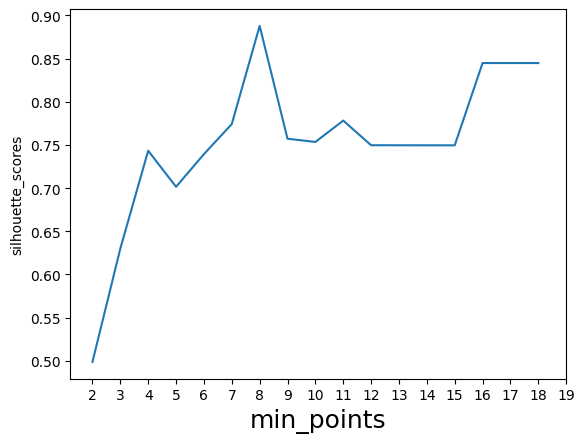

In [7]:
x = model_selection_df[model_selection_df['cluster_count'] > 2]['min_points']
y = model_selection_df[model_selection_df['cluster_count'] > 2]['silhouette_score']

plt.plot(x, y)
plt.ylabel('silhouette_scores')
plt.xlabel('min_points', fontsize=18)
plt.xticks(min_points)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### Chosen Parameters Clustering

(5519503,)
(3323, 3323)
Optimal epsilon (eps): 0.5002798630146741
Knee point index: 3235


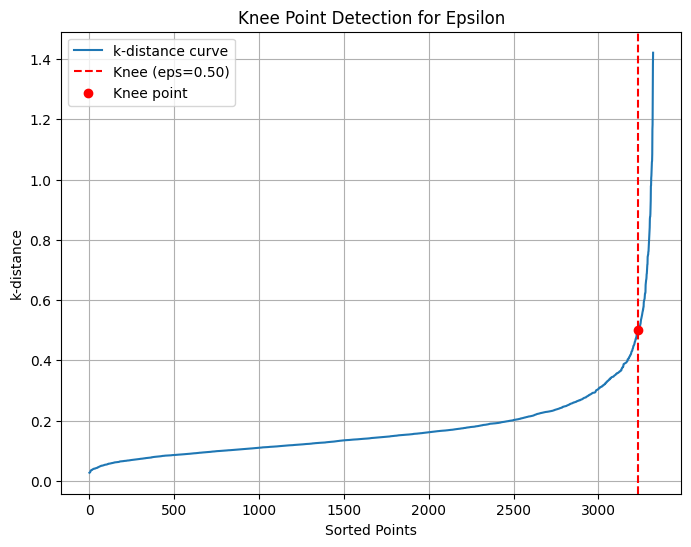

In [ ]:
min_points = 6 # found throught model selection

dist = pdist(data_scaled, 'euclidean') #pair wise distance
print (dist.shape)
dist = squareform(dist) #distance matrix given the vector dist
print(dist.shape)

k = min_points - 1 #standard value?
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

sorted_distances = sorted(kth_distances)
indices = range(0, len(kth_distances))

# Use the KneeLocator to find the knee point
kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

# Get the knee (optimal epsilon)
optimal_eps = sorted_distances[kneedle.knee]  # The y-value at the knee
optimal_index = kneedle.knee  # The x-value (index)

print(f"Optimal epsilon (eps): {optimal_eps}")
print(f"Knee point index: {optimal_index}")

# Plot the k-distance graph with the knee point marked
plt.figure(figsize=(8, 6))
plt.plot(indices, sorted_distances, label="k-distance curve")
plt.axvline(optimal_index, linestyle="--", color="r", label=f"Knee (eps={optimal_eps:.2f})")
plt.scatter(optimal_index, optimal_eps, color="red", label="Knee point", zorder=5)
plt.xlabel("Sorted Points")
plt.ylabel("k-distance")
plt.title("Knee Point Detection for Epsilon")
plt.legend()
plt.grid()
plt.show()

Selection of best eps

In [9]:
# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_points)
clusters = dbscan.fit_predict(data_scaled)

# Add cluster labels to the data
data_for_clustering['cluster'] = clusters

# Display cluster distribution
print(data_for_clustering['cluster'].value_counts())
print(data_for_clustering.head())

cluster
 0    3250
-1      43
 1      13
 2      11
 3       6
Name: count, dtype: int64
   length  race_prestige  race_physical_effort  cluster
4     5.2       0.193636              0.000015        0
5   135.0       0.193636              0.006662        0
6   100.0       0.193636              0.004484        0
7   199.0       0.193636              0.041416        0
8   244.0       0.193636              0.140635        0


/tmp/ipykernel_20033/4157897731.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters


In [10]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([  43, 3250,   13,   11,    6]))

In [11]:
# Identify outliers (cluster label -1)
outliers = data_for_clustering[data_for_clustering['cluster'] == -1]
print("\nNumber of outliers:", len(outliers))


Number of outliers: 43


In [12]:
# Analyze the mean and standard deviation of numerical features for each cluster
cluster_stats = data_for_clustering.groupby('cluster').agg(['mean', 'std'])
print("Cluster Statistics:\n", cluster_stats)

Cluster Statistics:
              length            race_prestige           race_physical_effort  \
               mean        std          mean       std                 mean   
cluster                                                                       
-1       263.267442  24.388616      0.533114  0.289219             0.495801   
 0       166.505957  61.764882      0.158071  0.095415             0.153624   
 1       268.520769  11.665809      0.745169  0.037459             0.152882   
 2       260.215455   6.840718      0.709054  0.029899             0.641324   
 3       250.833333   5.269409      0.449906  0.035590             0.576750   

                   
              std  
cluster            
-1       0.295296  
 0       0.158603  
 1       0.034892  
 2       0.049710  
 3       0.025953  


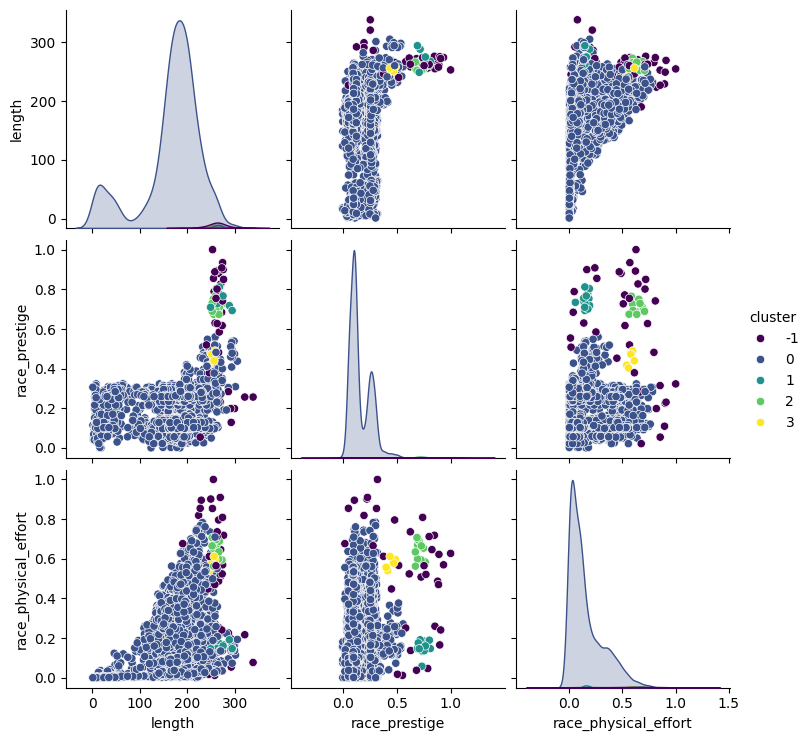

In [13]:
# Pair plot for a subset of columns
data_subset = data_for_clustering[['length','race_prestige', 'race_physical_effort', 'cluster']]
sns.pairplot(data_subset, hue='cluster', palette='viridis')
plt.show()

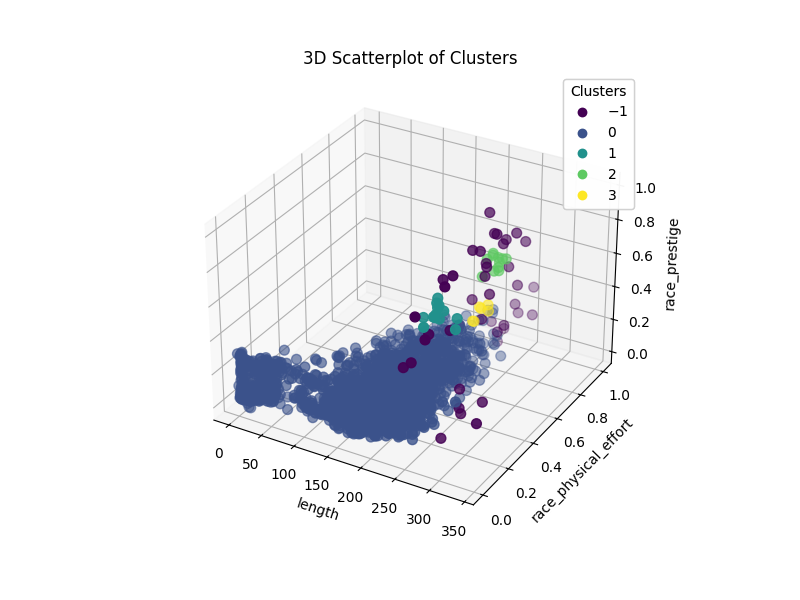

In [14]:
%matplotlib widget

x = data_for_clustering['length']  # Prima feature
y = data_for_clustering['race_physical_effort']  # Seconda feature
z = data_for_clustering['race_prestige']  # Terza feature

# Crea il grafico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot
scatter = ax.scatter(x, y, z, c=data_for_clustering['cluster'], cmap='viridis', s=50)
ax.set_xlabel('length')
ax.set_ylabel('race_physical_effort')
ax.set_zlabel('race_prestige')

# Aggiungi una legenda (opzionale)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title('3D Scatterplot of Clusters')

# Abilita la modalità interattiva
plt.ion()
plt.show()

Analysing the plots, we can see that density-based clustering through DBSCAN revealed the presence of four relevant clusters.
In particular, looking at the data with respect to the size of the ‘race_physical_effort’ and ‘race_prestige’ features, we can clearly observe the result of DBSCAN's behaviour, with clusters of varying shapes and densely packed within them.

The clusters can be analysed as follows (colour references and labels in the plots):
- yellow (3) : race_prestige (0.4-0.5), race_physical_effort (0.5-0.6)
- green (2): race_prestige (0.7-0.8), race_physical_effort (0.5-0.7)
- teal (1): race_prestige (0.7-0.8), race_physical_effort (0.1-0.2)
- dark blue (-1): outliers
- blue (0): remaining records



In [15]:
data_scaled = scaler.fit_transform(data_for_clustering[data_for_clustering['cluster'] != -1])
no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

In [16]:
print('Silhouette %s' % silhouette_score(data_scaled, no_out_labels))

Silhouette 0.739408058579136


The silhouette value obtained confirms that the clusters are ‘well defined’ and logically ‘compact’